## Demonstration of how `sfrmaker` handles streambed elevations

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import flopy
fm = flopy.modflow
import matplotlib.pyplot as plt
from sfrmaker import Lines, StructuredGrid
from sfrmaker.utils import assign_layers


flopy is installed in /Users/aleaf/Documents/GitHub/flopy/flopy


### Run the first part of the Tyler Forks example problem to get an `SFRData` instance

In [2]:
# NHDPlus input files (see the input requirements in the SFRmaker readme file
# (Note that multiple datasets can be supplied as lists
# when the SFR area covers multiple drainage basins)
data_dir = '../data/badriver'
pfvaa_files = ['{}/PlusFlowlineVAA.dbf'.format(data_dir)]
plusflow_files = ['{}/PlusFlow.dbf'.format(data_dir)]
elevslope_files = ['{}/elevslope.dbf'.format(data_dir)]
flowlines = ['{}/NHDflowlines.shp'.format(data_dir)]

# DEM for sampling streambed top elevations
dem = '{}/dem_26715.tif'.format(data_dir)

# output folder
outdir = 'temp/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

# make an instance of the sfrmaker.Lines class from NHDPlus data
# use a shapefile of the model grid to filter what is read in
# (only flowlines within the bounding box of the grid)
lns = Lines.from_nhdplus_v2(NHDFlowlines=flowlines,
                            PlusFlowlineVAA=pfvaa_files,
                            PlusFlow=plusflow_files,
                            elevslope=elevslope_files,
                            filter='{}/grid.shp'.format(data_dir))

# make a flopy StructuredGrid instance
# that represents the model grid
m = fm.Modflow.load('tf.nam', model_ws='{}/tylerforks'.format(data_dir))

# delr and delc have to specified in meters (consistent with projected CRS)
mg = flopy.discretization.StructuredGrid(delr=m.dis.delr.array * .3048,  # cell spacing along a row
                                         delc=m.dis.delc.array * .3048,  # cell spacing along a column
                                         xoff=682688, yoff=5139052,  # lower left corner of model grid
                                         angrot=0,  # grid is unrotated
                                         proj4='epsg:26715'
                                         # projected coordinate system of model (UTM NAD27 zone 15 North)
                                         )
m.modelgrid = mg

# make a sfrmaker.StructuredGrid instance from the flopy grid
# active_area is a polygon that specifies the area where SFR reaches will be populated
grd = StructuredGrid.from_modelgrid(mg,
                                    active_area='{}/active_area.shp'.format(data_dir)
                                    )

# from the lines and StructuredGrid instances, make a sfrmaker.SFRData instance
# (lines are intersected with the model grid and converted to reaches, etc.)
# unfortunately there are 3 different ways to specify model length units
# SFRmaker will set the units in this order of priority:
# 1) as argued with model_length_units= (below)
# 2) units attached to sfrmaker.StructuredGrid instance
# 3) units attached to DIS package of flopy model
# if the grid or model dis package have valid units, any conversions should "just work"
# in any case, specifying units in the to_sfr call guarantees that the correct units will be used
sfr = lns.to_sfr(grd, model_length_units='feet', model=m)


loading NHDPlus v2 hydrography data...


/Users/aleaf/opt/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:393: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return CRS(_prepare_from_string(in_crs_string))
/Users/aleaf/opt/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)



reading ../data/badriver/NHDflowlines.shp...
filtering on bounding box -90.624482596925, 46.37886827710283, -90.4625592199325, 46.45832567355404...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)

load finished in 0.50s

Getting routing information from NHDPlus Plusflow table...
finished in 0.05s


reading ../data/badriver/active_area.shp...
--> building dataframe... (may take a while for large shapefiles)
setting isfr values...
Intersecting 1 features...
1
finished in 0.54s

SFRmaker version 0.4.0.post16.dev0+g65522d8

Creating sfr dataset...
Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length unit

### Sample elevations from the DEM
* the **buffers** method draws a buffer around each LineString representing a reach (default=100m), and then gets the minimum DEM elevation within that buffer, using the **`rasterstats`** package
* alternatively, the **`cell polygons`** method would do the same thing using the model cell polygons instead to represent the reaches
* get results with and without smoothing. 

#### pseudo code for the smoothing algoritm:  


```
Starting at the outlets to the stream network, list the reaches at each level (reaches that route to an outlet, reaches that route to reaches that route to an outlet, etc...)
For each level:
    For each stream reach within the level:
        Get the elevations of all upstream reaches (that route to that reach)
            Set the elevation as the minimum of the elevation sampled at the current reach and the elevations sampled at all upstream reaches.
```
        

In [3]:
raw_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=False)
smooth_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=True)

running rasterstats.zonal_stats on buffered LineStrings...
finished in 2.94s

running rasterstats.zonal_stats on buffered LineStrings...
finished in 2.75s


Smoothing elevations...
finished in 0.13s


### Make comparison plots of the elevations in each segment
* model_top: elevations sampled from the DEM at the cell centers
* nhdplus_elevations: reach elevations linearly interpolated from original COMID end elevations in NHDPlus
* raw_sampled_elevs: minimum DEM elevations within each buffered LineString
* smooth_sampled_elevs: minimum DEM elevations within each buffered LineString with smoothing applied

#### Note:
One of the segments has NHDPlus elevations that are much higher than the model top or DEM. This is due to the segment originating outside of the model domain, which means the COMID start elevation from NHDPlus is invalid.

In [4]:
dfs = []
segments = sfr.reach_data.groupby('iseg')
for iseg, srd in segments:
    df = srd.copy()
    df['dist'] = srd.rchlen.cumsum()
    df['nhdplus elevations'] = df.strtop
    dfs.append(df[['i', 'j', 'rno', 'iseg', 'ireach', 'dist', 'nhdplus elevations']])
df = pd.concat(dfs)
df['model top'] = sfr.model.dis.top.array[df.i, df.j]
df['raw sampled elevations'] = [raw_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smoothed sampled elevations'] = [smooth_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smoothed sampled elevations'] /= .3048 # convert from meters to feet
df['raw sampled elevations'] /= .3048

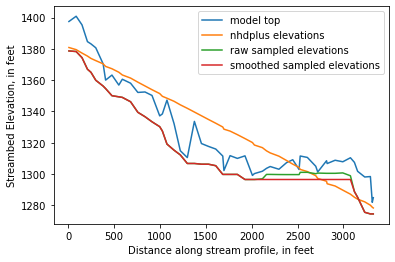

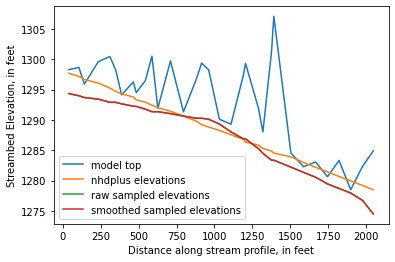

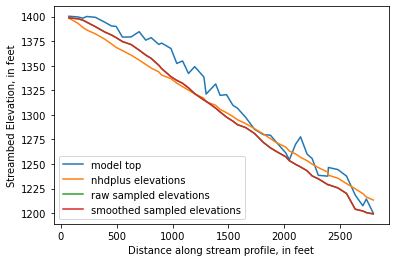

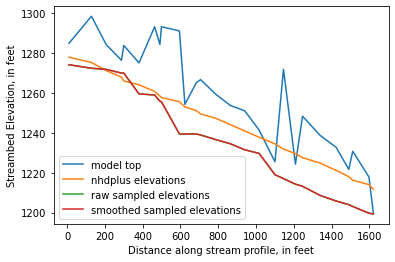

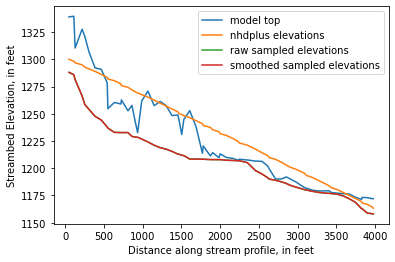

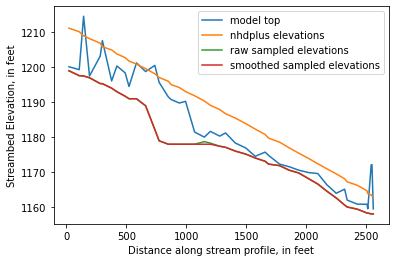

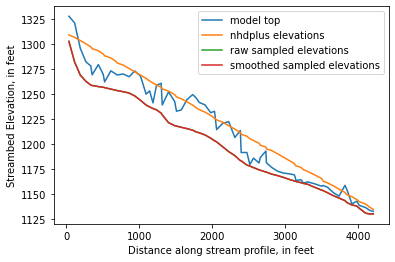

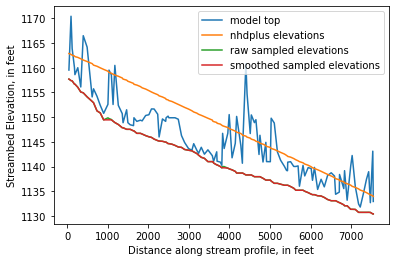

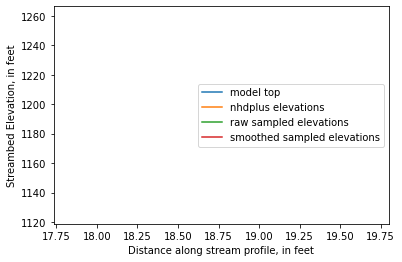

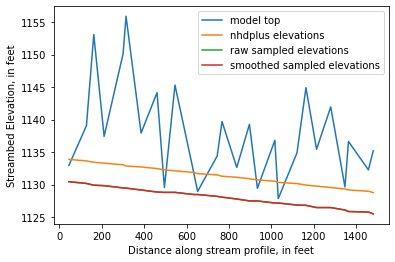

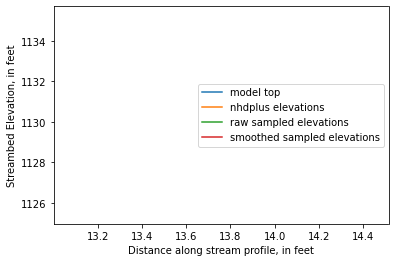

In [5]:
segments = df.groupby('iseg')
for iseg, srd in segments:
    srd = srd.copy()
    srd.index = srd.dist
    ax = srd[['model top', 'nhdplus elevations', 'raw sampled elevations', 'smoothed sampled elevations']].plot()
    ax.set_xlabel('Distance along stream profile, in feet')
    ax.set_ylabel('Streambed Elevation, in feet')
    
    # save the profile that begins with segment 1
    if iseg == 1:
        plt.savefig('streambed_elevations_comp.pdf')